In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In this notebook, we will use the first lockdown as an examlpe while we explore different methods to model our daily covid cases. Below we explore 3 techniques:

1) Linear regression.

2) Linear Regression with Polynomials.

3) Linear Regression with ln(y) transformation.

**Inlcude**
* The 20/3/2020 lockdown
* The reopening of schools on 31/8/2020
* The 25/12/2020 lockdown

In [52]:
df = pd.read_csv('COVID19_Qc_RapportINSPQ_HistoVigie.csv')

# 2020-01-22 to 2023-02-20

In [53]:
# The three interested events are between 2020 and 2021 - Let's just select the rows around these years

covid = df.loc[(df.Date >='2020-03-01') & (df.Date <= '2021-02-01')]
covid['Nb_Nvx_Cas_ln'] = np.log1p(covid['Nb_Nvx_Cas'])
covid

C:\Users\jorda\AppData\Local\Temp\ipykernel_3928\12693380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid['Nb_Nvx_Cas_ln'] = np.log1p(covid['Nb_Nvx_Cas'])
C:\Users\jorda\AppData\Local\Temp\ipykernel_3928\12693380.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid['Nb_Nvx_Cas_poly'] = np.power(covid['Nb_Nvx_Cas'], 2)


,Date,Nb_Cas_Cumulatif,Nb_Nvx_Cas,Nb_Deces_Cumulatif_Total,Nb_Deces_Cumulatif_CHCHSLD,Nb_Deces_Cumulatif_RPA,Nb_Deces_Cumulatif_DomInc,Nb_Deces_Cumulatif_Autre,Nb_Nvx_Deces_Total,Nb_Nvx_Deces_CHCHSLD,Nb_Nvx_Deces_RPA,Nb_Nvx_Deces_DomInc,Nb_Nvx_Deces_Autre,Nb_Nvx_Cas_ln,Nb_Nvx_Cas_poly
39,2020-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0
40,2020-03-02,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0
41,2020-03-03,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0
42,2020-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0
43,2020-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,2021-01-28,252391,1314,9920,5545,2065,1797,513,37,12,11,13,1,7.181592,1726596
373,2021-01-29,253671,1280,9959,5556,2073,1815,515,39,11,8,18,2,7.155396,1638400
374,2021-01-30,254884,1213,9986,5566,2075,1827,518,27,10,2,12,3,7.101676,1471369
375,2021-01-31,255802,918,10022,5578,2083,1842,519,36,12,8,15,1,6.823286,842724


In [54]:
pd.to_datetime(covid.Date)

39    2020-03-01
40    2020-03-02
41    2020-03-03
42    2020-03-04
43    2020-03-05
         ...    
372   2021-01-28
373   2021-01-29
374   2021-01-30
375   2021-01-31
376   2021-02-01
Name: Date, Length: 338, dtype: datetime64[ns]

In [55]:
def plot_rdd(est_model, x_hat, x_axis, threshold_, ax):
    
    '''
    This function plots the predicted line of RDD
    '''
    
    # get the coefficients from the estimate model
    beta0 = est_model.params['const']
    beta1 = est_model.params['Days']
    beta2 = est_model.params['Threshold']
    beta3 = est_model.params['Days:Threshold']
    
    
    # make predictions witht the estimate model
    y_hat = est_model.predict(x_hat)
    
    # make a discontinuous plot by removing the connection between the two parts of RDD 
    y_hat.iloc[threshold] = np.nan
    
    # get the extended line from the second part of RDD starting from the threshold
    x2 = pd.DataFrame({'x':[threshold, threshold + 3]})
    y2 = beta0 + beta1*x2 + beta2 + beta3*x2
    
    # plot
    ax.plot(x_axis, y_hat, color = 'red', lw = 2)
    ax.plot(x2, y2 , color = 'red', lw = 2)
    ax.axvline(x = threshold)

def plot_rdd2(est_model, x_hat, x_axis, threshold_, ax):
    
    '''
    This function plots the predicted line of RDD
    '''
    
    # get the coefficients from the estimate model
    beta0 = est_model.params['const']
    beta1 = est_model.params['Days2']
    beta2 = est_model.params['Threshold']
    beta3 = est_model.params['Days:Threshold2']
    
    
    # make predictions witht the estimate model
    y_hat = est_model.predict(x_hat)
    
    # make a discontinuous plot by removing the connection between the two parts of RDD 
    y_hat.iloc[threshold] = np.nan
    
    # get the extended line from the second part of RDD starting from the threshold
    x2 = pd.DataFrame({'x':[threshold, threshold + 3]})
    y2 = beta0 + beta1*x2 + beta2 + beta3*x2
    
    # plot
    ax.plot(x_axis, y_hat, color = 'red', lw = 2)
    ax.plot(x2, y2 , color = 'red', lw = 2)
    ax.axvline(x = threshold)

In [56]:
temp_df = lambda date1,date2: covid.loc[(covid.Date >= date1) & (covid.Date <= date2)]

# get our temporary dataframe for each event
lock1 = temp_df('2020-03-01', '2020-05-30')
reop = temp_df('2020-07-07', '2020-10-07')
lock2 = temp_df('2020-10-31', '2021-04-30')

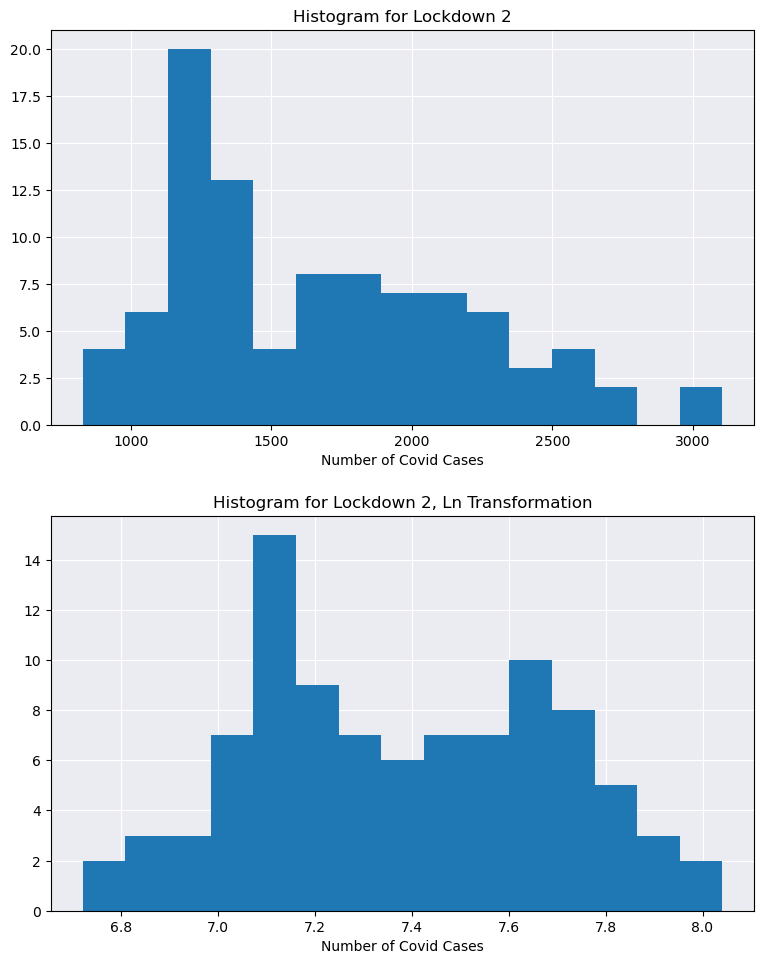

In [104]:
fig, (ax1) = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 10))

# --- Histogram for Lockdown 1
ax1[0].hist(lock2.Nb_Nvx_Cas, bins = 15, zorder=2)
ax1[0].set_xlabel('Number of Covid Cases')
ax1[0].set_title('Histogram for Lockdown 2')

ax1[0].grid(zorder=1)
ax1[0].grid(color='white')
ax1[0].set_facecolor((0.92,0.92,0.95))

# --- Histogram for ln transformation
ax1[1].hist(lock2.Nb_Nvx_Cas_ln, bins = 15, zorder=2)
ax1[1].set_xlabel('Number of Covid Cases')
ax1[1].set_title('Histogram for Lockdown 2, Ln Transformation')

ax1[1].grid(zorder=1)
ax1[1].grid(color='white')
ax1[1].set_facecolor((0.92,0.92,0.95))

fig = plt.tight_layout(pad = 2.)
plt.show()

As seen in the first histogram, we have a non-normal ditribution of data.

In the second histogram we can see that a Log transformation can help sooth data that is primarily on one of the two extremes.

___
## Lockdown 2 Modeling

Here we will run regressions on lockdown 2 to see which data transformation provides the most reliable results.

Since we are interested in the effect of the lockdown, we are mostly interested in the values of our coefficients. A strong R^2 is desired as well. We are looking for coefficients with the lowest Standard Error possible, so we can be the most confident in our assesments.

In [157]:
# Lockdown 2 
threshold = 69

lock2 = covid.loc[(covid.Date >= '2020-10-31') & (covid.Date <= '2021-04-30')][['Date','Nb_Nvx_Cas','Nb_Nvx_Cas_ln', 'Nb_Nvx_Cas_poly']]
lock2.insert(1, 'Days', range(1, 1 + len(lock2)))
lock2['Threshold'] = lock2.Days.apply(lambda x: int(threshold < x))
lock2['Days:Threshold'] = lock2.Days * lock2['Threshold']


In [166]:
# Train the model
X = lock2[['Days','Threshold','Days:Threshold']]
X = sm.add_constant(X)

X_poly = X.copy(deep=True)
X_poly['Days_2'] = np.power(X_poly['Days'], 2)
X_poly['Days:Threshold_2'] = np.power(X_poly['Days:Threshold'], 2)
X_poly = X_poly[['Threshold', 'Days_2', 'Days:Threshold_2']]
X_poly = sm.add_constant(X_poly)

In [167]:
Y = lock2.Nb_Nvx_Cas

est = sm.OLS(Y,X).fit(cov_type = 'HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     156.5
Date:                Sun, 04 Jun 2023   Prob (F-statistic):           1.38e-35
Time:                        13:10:48   Log-Likelihood:                -630.36
No. Observations:                  94   AIC:                             1269.
Df Residuals:                      90   BIC:                             1279.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            818.4062     51.472     15.900      0.000     717.524     919.289
Days              25.5420      1.400     18.243      0.000      22.798      28.286
Threshold       5121.6338    425.348     12.041      0.000    4287.968    5955.300
Days:Threshold   -78.6420      5.166    -15.222      0.000     -88.768     -68.516
==============================================================================
Omnibus:                       13.851   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.886
Skew:                           0.693   Prob(JB):                     7.92e-05
Kurtosis:                       4.703   Cond. No.                     1.46e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
Y_poly = lock2.Nb_Nvx_Cas

est_poly = sm.OLS(Y_poly,X_poly).fit(cov_type = 'HC2')
est_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     162.1
Date:                Sun, 04 Jun 2023   Prob (F-statistic):           3.66e-36
Time:                        13:11:39   Log-Likelihood:                -620.38
No. Observations:                  94   AIC:                             1249.
Df Residuals:                      90   BIC:                             1259.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1127.1304     28.114     40.092      0.000    1072.029    1182.232
Threshold         2639.3507    225.580     11.700      0.000    2197.222    3081.480
Days_2               0.3609      0.019     19.268      0.000       0.324       0.398
Days:Threshold_2    -0.6827      0.036    -19.034      0.000      -0.753      -0.612
==============================================================================
Omnibus:                       10.832   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.690
Skew:                           0.540   Prob(JB):                     0.000646
Kurtosis:                       4.608   Cond. No.                     5.93e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 5.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [165]:
Y_ln = lock2.Nb_Nvx_Cas_ln

est_ln = sm.OLS(Y_ln,X).fit(cov_type = 'HC2')
est_ln.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Nb_Nvx_Cas_ln   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     188.0
Date:                Sun, 04 Jun 2023   Prob (F-statistic):           1.25e-38
Time:                        13:09:50   Log-Likelihood:                 74.007
No. Observations:                  94   AIC:                            -140.0
Df Residuals:                      90   BIC:                            -129.8
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.8734      0.033    210.571      0.000       6.809       6.937
Days               0.0149      0.001     20.590      0.000       0.014       0.016
Threshold          3.2478      0.257     12.618      0.000       2.743       3.752
Days:Threshold    -0.0489      0.003    -15.163      0.000      -0.055      -0.043
==============================================================================
Omnibus:                        0.954   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.691
Skew:                          -0.209   Prob(JB):                        0.708
Kurtosis:                       3.051   Cond. No.                     1.46e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The above resutls:

1) No transformations:
- R^2 = 0.856
- Days Coefficient: 25.5420 Standard Error: 1.400
- Days:Threshold Coefficient: -78.6420 Standard Error: 5.166
- Confidence Interval as % of Coefficent: 21.48% and 25.8%

2) Polynomial (power of 2) values for days:
- R^2 = 0.883
- Days_2 Coefficient: 0.3609 Standard Error: 0.019
- Days:Threshold_2 Coefficient: -0.6827	Standard Error: 0.036
- Confidence Interval as % of Coefficent: 21.1% and 20.9%

1) Log Transformation of Y value:
- R^2 = 0.871
- Days Coefficient: 0.0149 Standard Error: <0.001
- Days:Threshold Coefficient: -0.0489 Standard Error: 0.003
- Confidence Interval as % of Coefficent: 13.4% and 21.4%

While the model with Polynomial transformation of days (x values) performed the best in regards to R^2, there are some things to mention in order to explain why I choose LN transformation of daily new cases (Y) in the end.

1) Polynomials are more sensitive to outliers.

2) Fitting on a polynomial did help R^2, but it produced a higher standard error relative to coefficients.

3) Polynomials add complexity and reduce interpretability of our model where we want to do a simple before/after analysis.

4) While not related to polynomials, our dependent is not normally distributed.

Based on the above reasons, we chose to move forward with our analysis using LN(Y) transformation for our daily new cases. While R^2 is lower than the Polynomial model, we must remember our goal. We want to best measure the effect of lockdowns/re-openings on daily new cases. So we must take the route that provides the most confidence in its coefficients. Perhaps if we were looking to predict future daily cases we would look at a model with higher R^2.
